In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM, TimeDistributed, Lambda
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.losses import mean_squared_error

Using TensorFlow backend.


In [3]:
file_path = "car_share_series2.csv"
data = pd.read_csv(file_path, index_col='timestamp')
data = data.drop([data.columns[0]] ,  axis='columns')

In [4]:
data.head()

,hour,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,weekday,usage
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-12-12 00:00:00,0,2,2,0,8,4,3,16,5,13,...,2,2,0,0,0,0,1,1,4,43
2018-12-12 01:00:00,1,1,2,0,8,4,3,15,5,13,...,2,2,0,0,0,0,1,1,4,45
2018-12-12 02:00:00,2,1,2,0,8,4,3,16,5,13,...,2,2,0,0,0,0,1,1,4,42
2018-12-12 03:00:00,3,1,2,0,7,4,3,15,5,14,...,2,2,0,0,0,0,1,1,4,49
2018-12-12 04:00:00,4,1,2,0,7,5,3,15,5,14,...,2,2,0,0,0,0,1,1,4,47


In [5]:
#We need create a target data, which is basically a copy of the data that will be later shifted
target_data = data.copy()
target_data = target_data.iloc[:,1:]
target_data = target_data.drop([target_data.columns[71]] ,  axis='columns')
target_data.head()

,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,usage
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-12-12 00:00:00,2,2,0,8,4,3,16,5,13,7,...,1,2,2,0,0,0,0,1,1,43
2018-12-12 01:00:00,1,2,0,8,4,3,15,5,13,6,...,1,2,2,0,0,0,0,1,1,45
2018-12-12 02:00:00,1,2,0,8,4,3,16,5,13,6,...,1,2,2,0,0,0,0,1,1,42
2018-12-12 03:00:00,1,2,0,7,4,3,15,5,14,6,...,0,2,2,0,0,0,0,1,1,49
2018-12-12 04:00:00,1,2,0,7,5,3,15,5,14,6,...,1,2,2,0,0,0,0,1,1,47


In [7]:
# For this excercise I will try to predict 24 horus in the future, since the data is taken hourly
shift_steps = 24

# Now that the target_data was created we need to shift the data so that the target values of 24 hours later aling with our
# input data

target_data = target_data.shift(-shift_steps)


In [9]:
target_data.tail(30)

,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,usage
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-07 18:00:00,1.0,5.0,0.0,16.0,6.0,6.0,14.0,5.0,13.0,9.0,...,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,20.0
2019-01-07 19:00:00,1.0,5.0,0.0,15.0,7.0,5.0,12.0,4.0,12.0,8.0,...,2.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,30.0
2019-01-07 20:00:00,1.0,3.0,0.0,15.0,7.0,3.0,15.0,3.0,11.0,9.0,...,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,30.0
2019-01-07 21:00:00,1.0,4.0,0.0,9.0,9.0,3.0,16.0,3.0,12.0,8.0,...,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,24.0
2019-01-07 22:00:00,1.0,4.0,0.0,7.0,9.0,3.0,16.0,3.0,10.0,8.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,32.0
2019-01-07 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we double check that because we shifted the target values now we have NaN values at the end

In [12]:
# Now we need to remove the rows with NaN values for the target data thus needing to exclude also the 24 lines from the input data

data_clean = data[:-shift_steps]
target_clean = target_data[:-shift_steps]

In [13]:
data_clean.shape,target_clean.shape

((576, 74), (576, 72))

We cans see that the shape has gone from (600,71) to (592,71)

In [14]:
# For the use of Neural Networks we need to convert the data to a numpy array

X_data = np.array(data_clean)
Y_data = np.array(target_clean)

In [15]:
print(X_data.shape,Y_data.shape)

(576, 74) (576, 72)


In [16]:
# For keras we data input has to have a (x,y,z) shape

X_data =X_data.reshape(1,X_data.shape[0],X_data.shape[1])
Y_data = Y_data.reshape(1,Y_data.shape[0],Y_data.shape[1])

print(X_data.shape,Y_data.shape)

(1, 576, 74) (1, 576, 72)


In [17]:
# Let's also use a 90% split of the data for validation

train_split = 0.9

n_train_rows = int(X_data.shape[1]*train_split)

X_train = X_data[:,0:n_train_rows]
X_test = X_data[:,n_train_rows:]
Y_train = Y_data[:,0:n_train_rows]
Y_test = Y_data[:,n_train_rows:]


In [18]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1, 518, 74) (1, 518, 72) (1, 58, 74) (1, 58, 72)


Now we need to Scale the data to feed it to the Neural Network

In [20]:
x_scaler = MinMaxScaler()

X_train_scale = x_scaler.fit_transform(X_train[0])
X_test_scale =  x_scaler.transform(X_test[0])


y_scaler = MinMaxScaler()

Y_train_scale = y_scaler.fit_transform(Y_train[0])
Y_test_scale = y_scaler.transform(Y_test[0])

C:\Users\Dell\Anaconda3\envs\kaggle\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
print(X_train_scale.shape, Y_train_scale.shape, X_test_scale.shape, Y_test_scale.shape)

(518, 74) (518, 72) (58, 74) (58, 72)


In [22]:
num_x_signal = X_train.shape[2]
num_y_signal = Y_train.shape[2]

In [41]:
batch_size = 400

sequence_length = 24

In [42]:
# So we are actually running a model for each department using each store as a batch.
import random as rand
from random import randint
from random import seed

def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signal)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, num_y_signal)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(n_train_rows - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X_train_scale[idx:idx+sequence_length]
            y_batch[i] = Y_train_scale[idx+sequence_length]

        
        yield (x_batch, y_batch)

In [43]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [44]:
x_batch, y_batch = next(generator)

In [45]:
print(x_batch.shape)
print(y_batch.shape)

(400, 24, 74)
(400, 72)


In [46]:
def batch_validation(sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Allocate a new array for the batch of input-signals.
    batch_size = X_test.shape[1] - sequence_length
    x_shape = (batch_size, sequence_length, num_x_signal)
    x_batch = np.zeros(shape=x_shape, dtype=np.float16)

    # Allocate a new array for the batch of output-signals.
    y_shape = (batch_size, num_y_signal)
    y_batch = np.zeros(shape=y_shape, dtype=np.float16)

    # Fill the batch with random sequences of data.
    for i in range(batch_size):

        # Copy the sequences of data starting at this index.
        x_batch[i] = X_train_scale[i:i+sequence_length]
        y_batch[i] = Y_train_scale[i+sequence_length]


    return (x_batch, y_batch)

In [47]:
X_test_scale, Y_test_scale = batch_validation(sequence_length)

In [48]:
validation_data = (X_test_scale, Y_test_scale)

print(validation_data[0].shape,validation_data[1].shape)

(34, 24, 74) (34, 72)


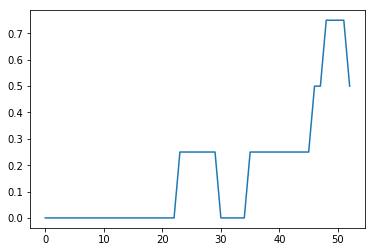

In [150]:
 plt.plot(Y_test_scale[:,2])

## Create Recurrent Neural Network

In [49]:
from keras.constraints import max_norm

model = Sequential()
model.add(LSTM(units=100,
              return_sequences=False,
              input_shape=(None,num_x_signal,)))
#model.add(TimeDistributed(Dense(num_y_signal, activation='sigmoid')))
model.add(Dense(num_y_signal,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               70000     
_________________________________________________________________
dense (Dense)                (None, 72)                7272      
Total params: 77,272
Trainable params: 77,272
Non-trainable params: 0
_________________________________________________________________


In [51]:
optimizer = Adam(lr=1e-3)

model.compile(loss=mean_squared_error, optimizer=optimizer)

In [53]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

mc = ModelCheckpoint("car_share_series.h5", monitor="val_loss", mode="min", save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-4)

In [54]:
%%time

history = model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=[es, mc, reduce_lr])

Epoch 1/100
100/100 [==============================] - 18s 182ms/step - loss: 0.0448 - val_loss: 0.0286
Epoch 2/100
100/100 [==============================] - 17s 166ms/step - loss: 0.0224 - val_loss: 0.0182
Epoch 3/100
100/100 [==============================] - 16s 161ms/step - loss: 0.0149 - val_loss: 0.0128
Epoch 4/100
100/100 [==============================] - 16s 160ms/step - loss: 0.0117 - val_loss: 0.0100
Epoch 5/100
100/100 [==============================] - 16s 161ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 6/100
100/100 [==============================] - 16s 161ms/step - loss: 0.0084 - val_loss: 0.0073
Epoch 7/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 8/100
100/100 [==============================] - 17s 166ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 9/100
100/100 [==============================] - 17s 165ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 10/100
100/100 [==============================] - 16s 161m

Epoch 79/100
100/100 [==============================] - 16s 163ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 80/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 81/100
100/100 [==============================] - 17s 166ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 82/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 83/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 84/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 85/100
100/100 [==============================] - 16s 164ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 86/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 87/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 88/100
100/100 [==============================] -

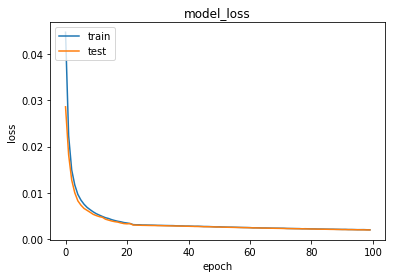

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
from keras.models import load_model

def plot_comparison():
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    model = tf.keras.models.load_model('car_share_series.h5')
    
    ypred = model.predict(X_test_scale)
    ypred_rescaled = np.round(y_scaler.inverse_transform(ypred))
    
    ytrue = np.round(y_scaler.inverse_transform(Y_test_scale))
    
    for neighborhood in range(Y_test_scale.shape[1]):  

        prediction = ypred_rescaled[:,neighborhood]
        true = ytrue[:,neighborhood]


        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))

        # Plot and compare the two neigborhood.
        plt.plot(true, label='true')
        plt.plot(prediction, label='pred')


        # Plot labels etc.
        plt.title("Neigh.ID: "+ target_data.columns[neighborhood])
        plt.ylabel("cars")
        plt.legend()
        plt.show()
    return(ypred_rescaled,ytrue)

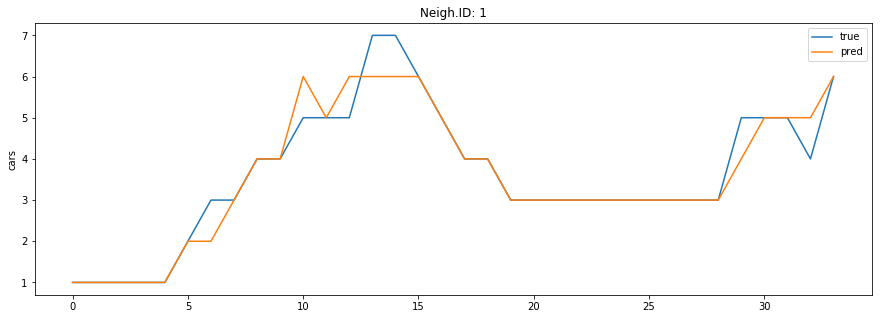

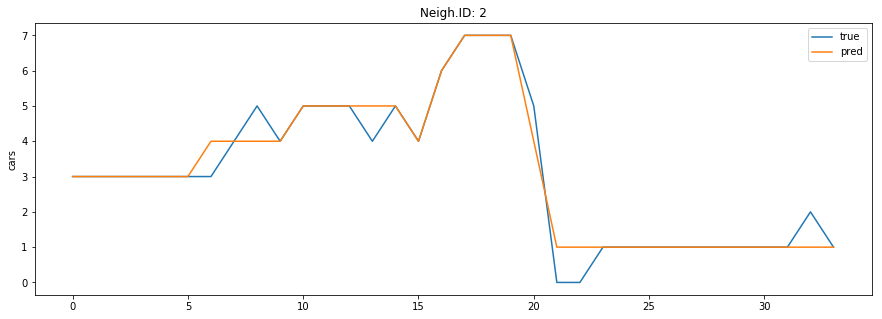

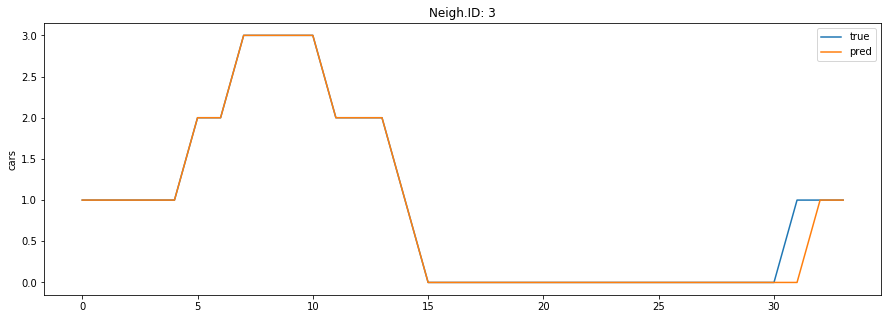

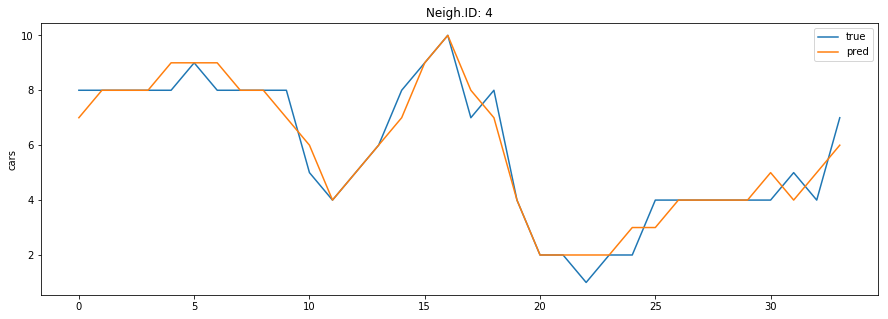

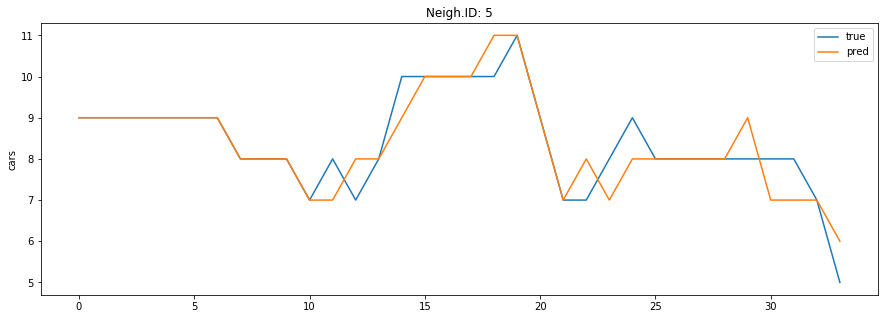

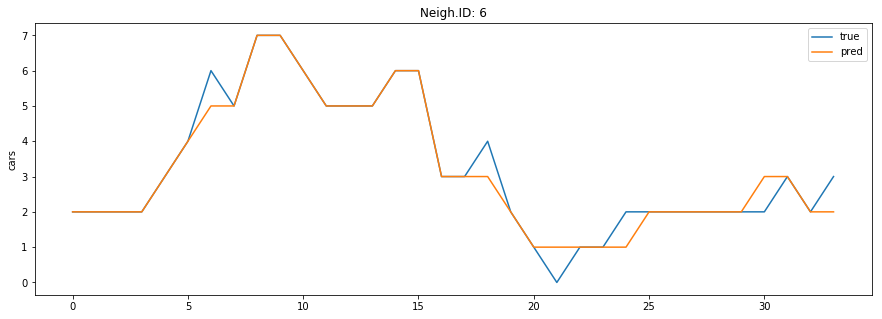

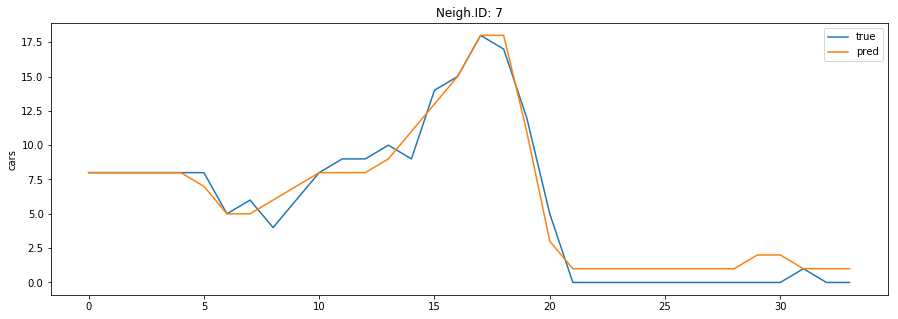

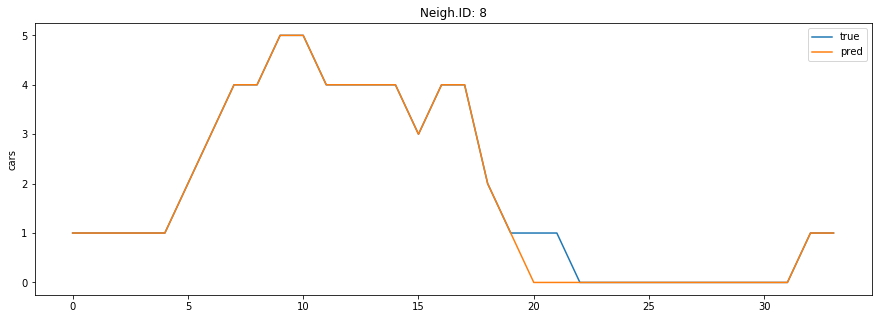

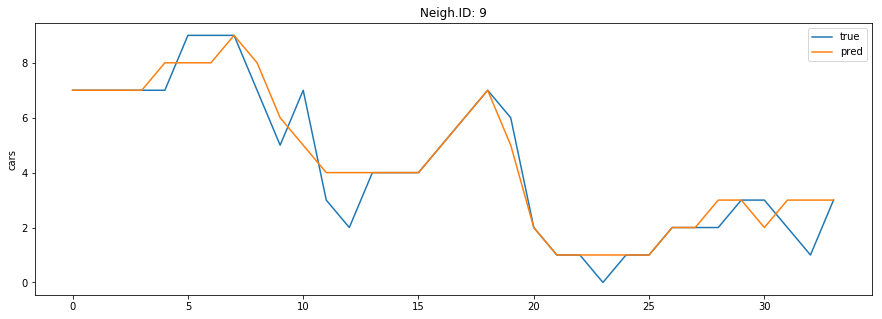

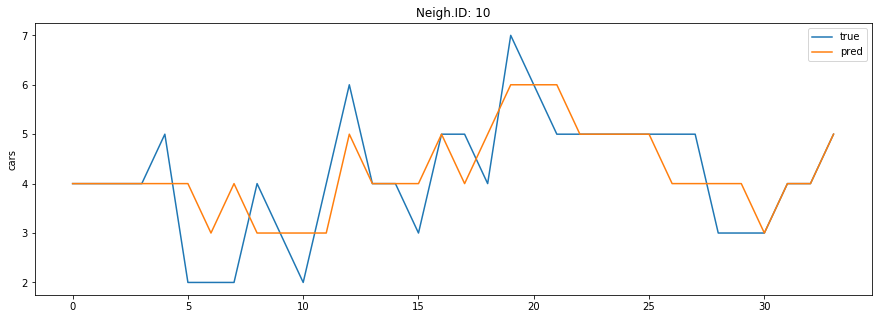

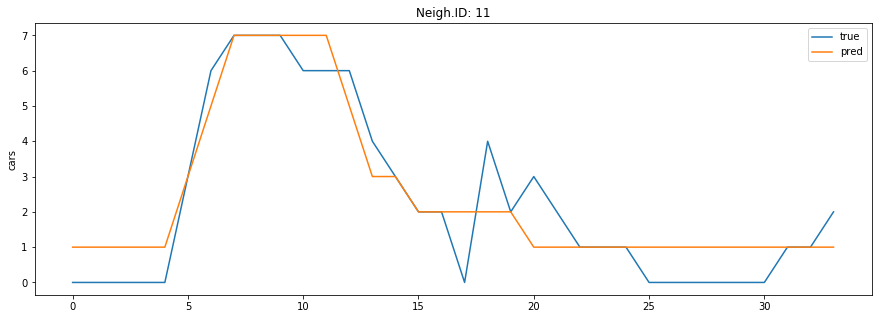

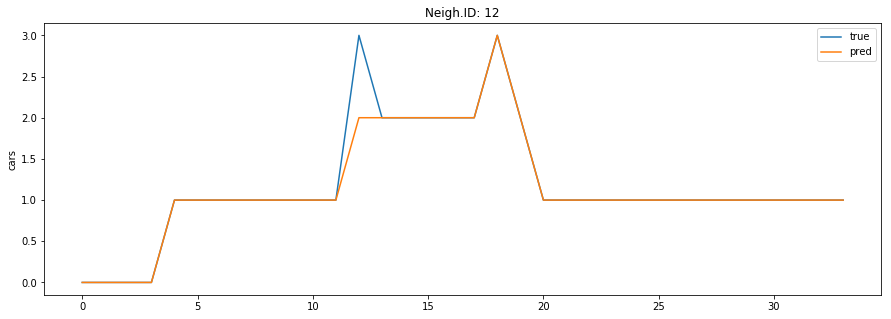

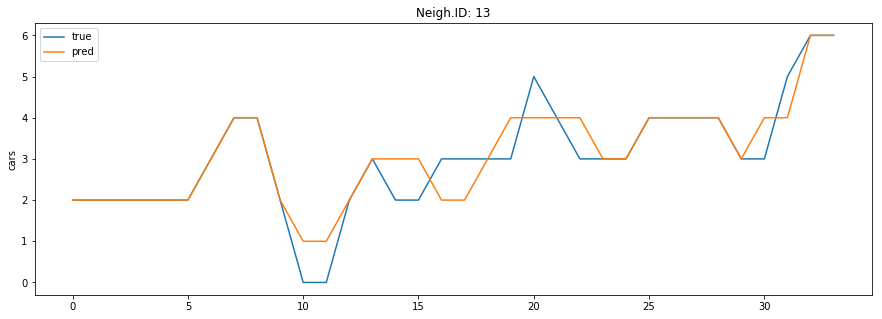

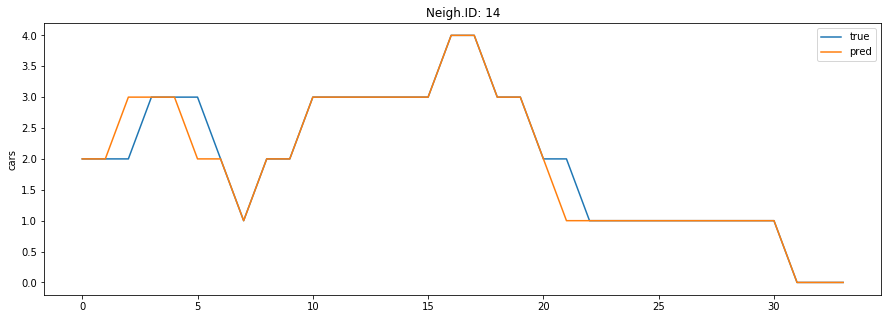

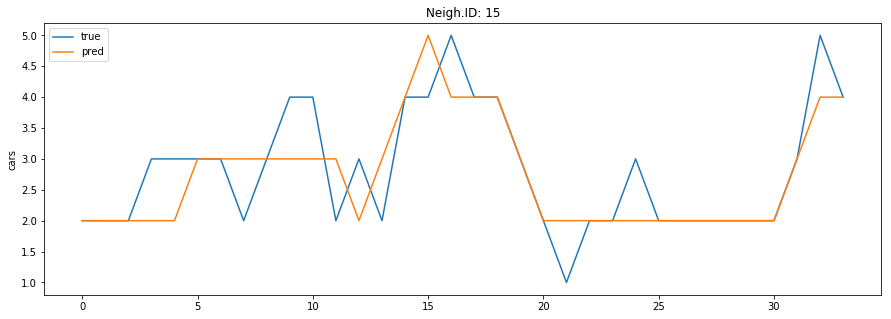

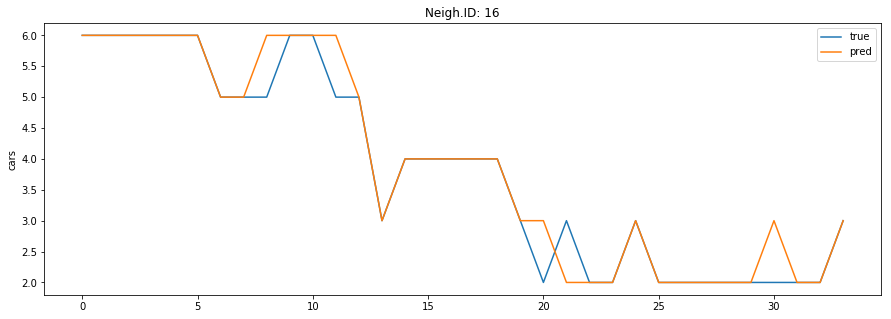

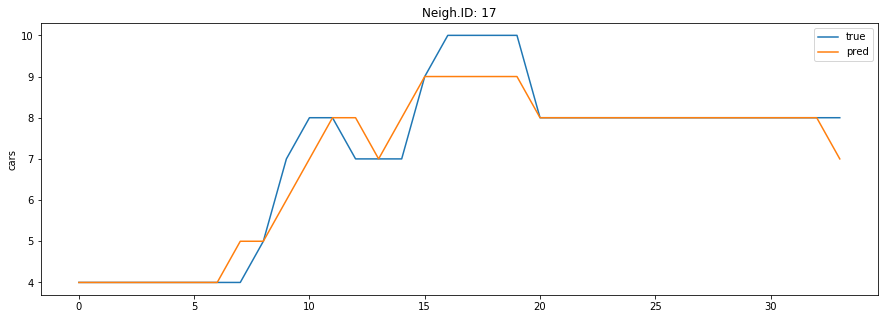

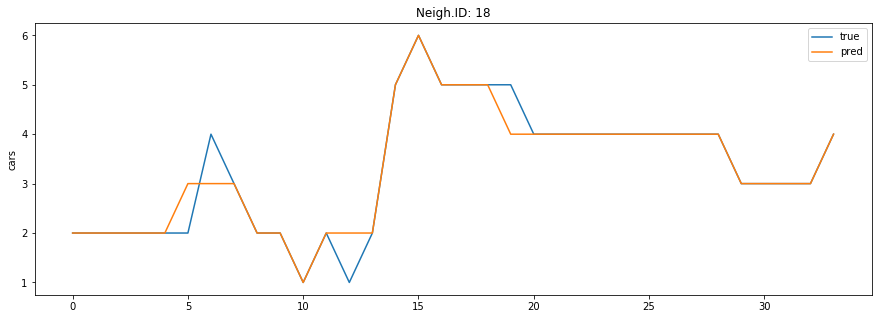

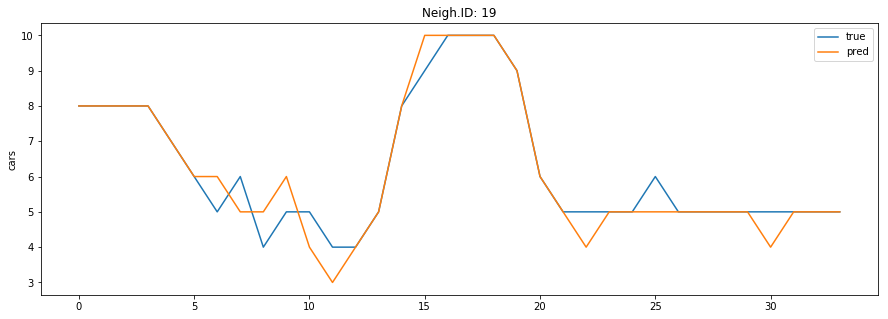

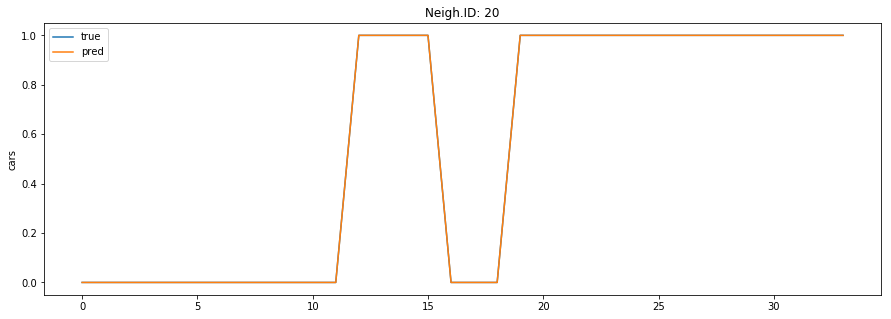

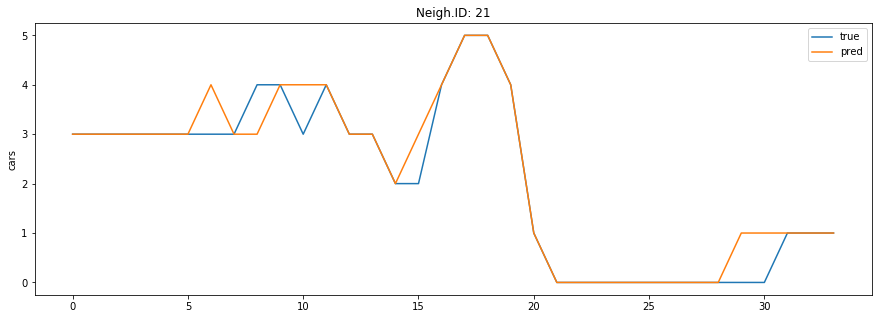

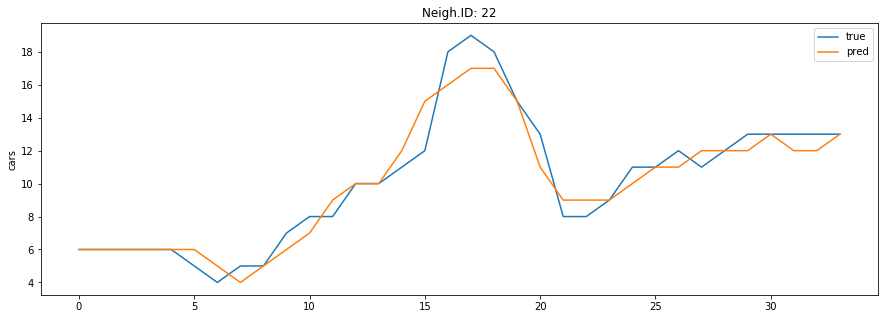

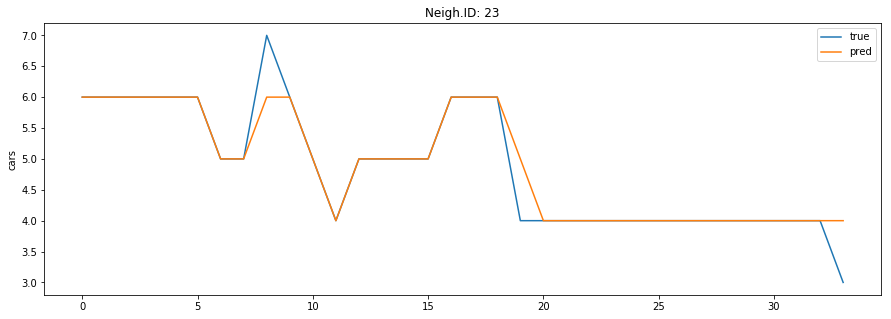

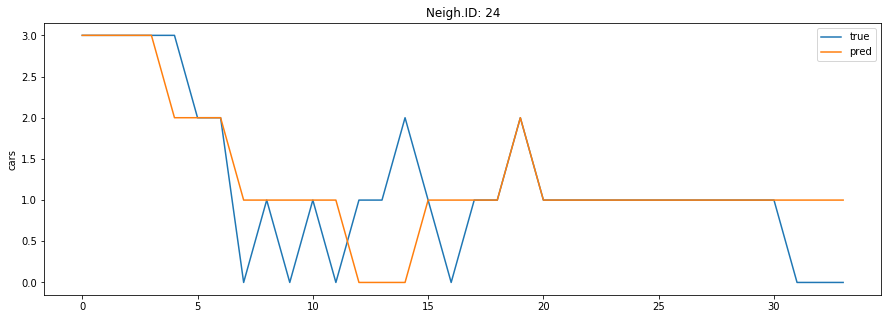

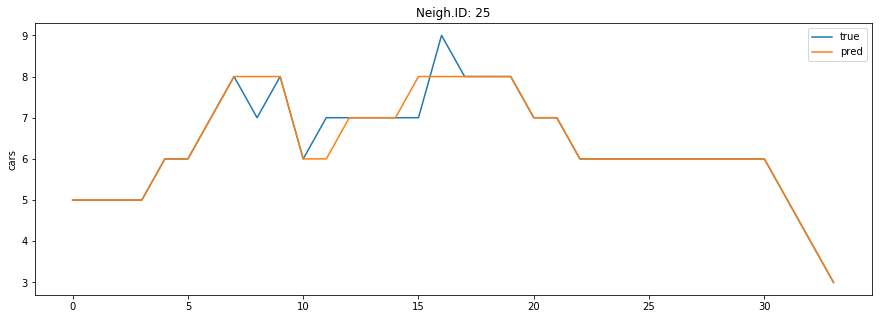

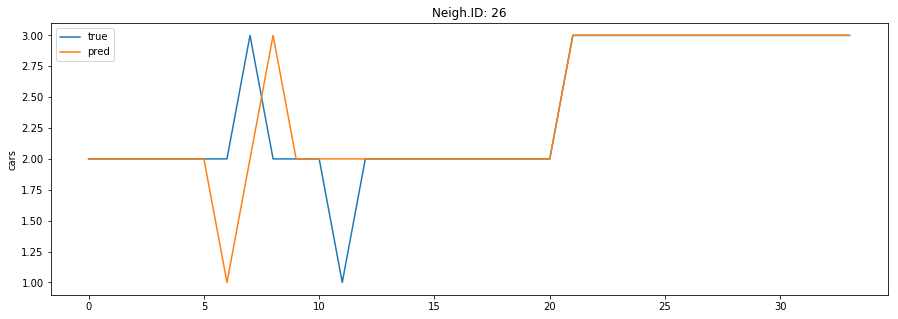

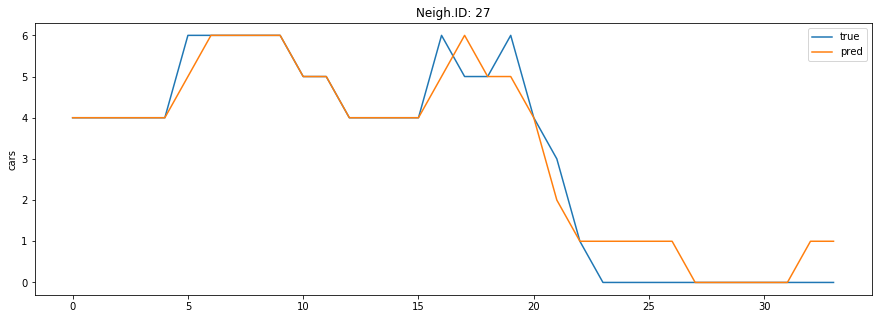

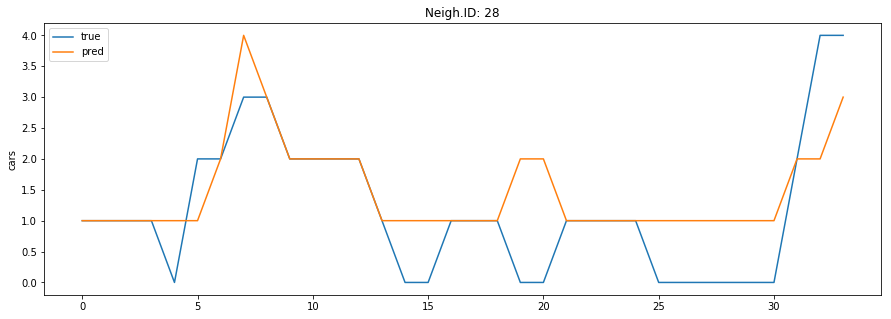

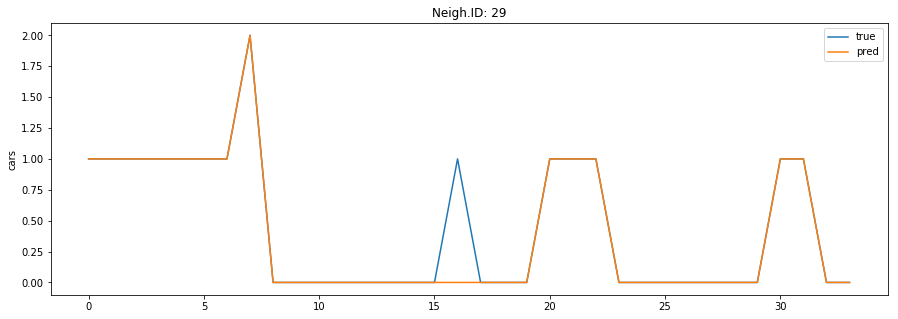

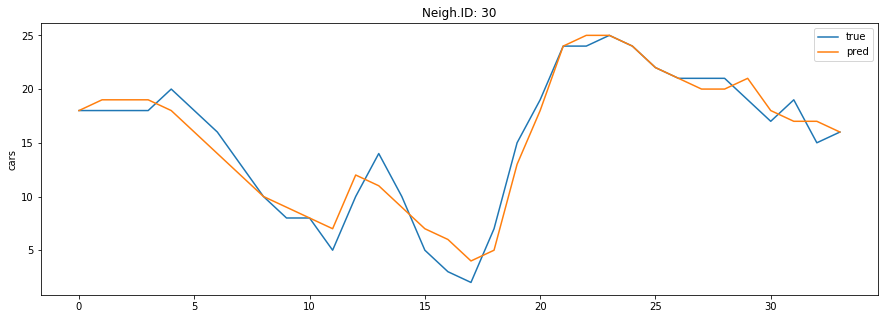

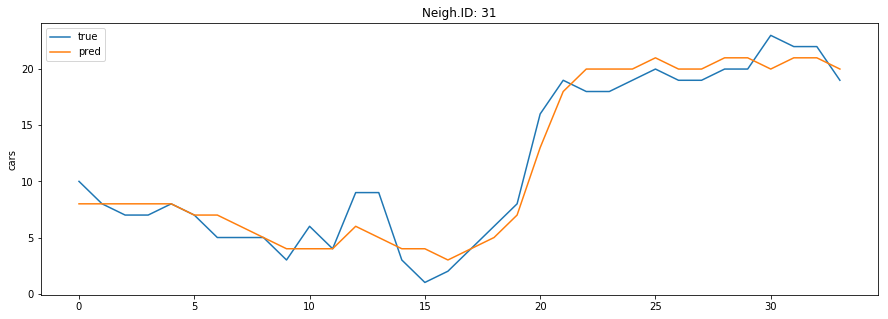

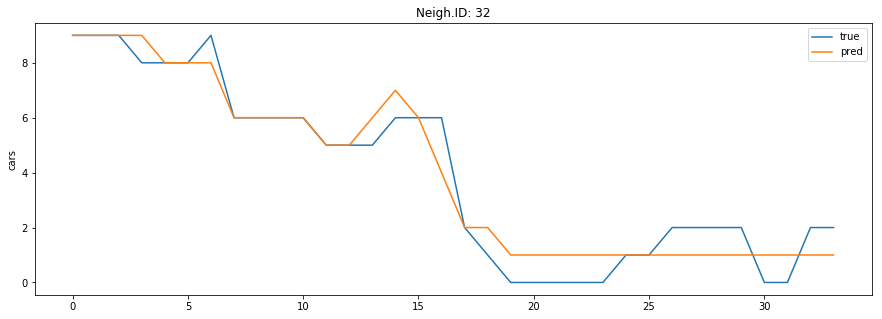

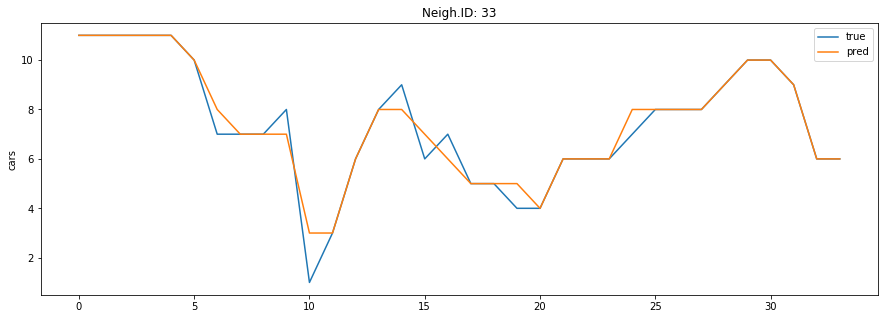

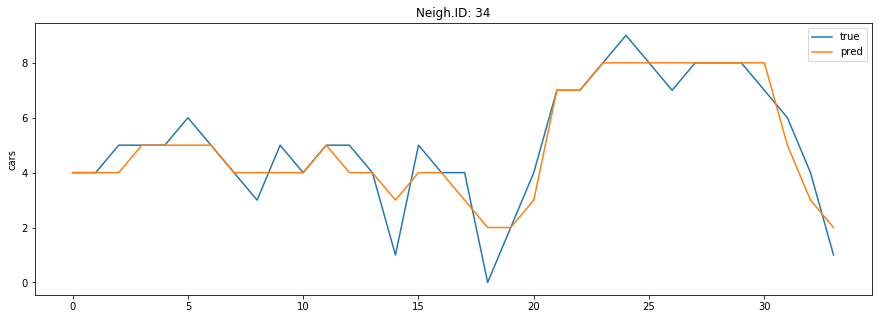

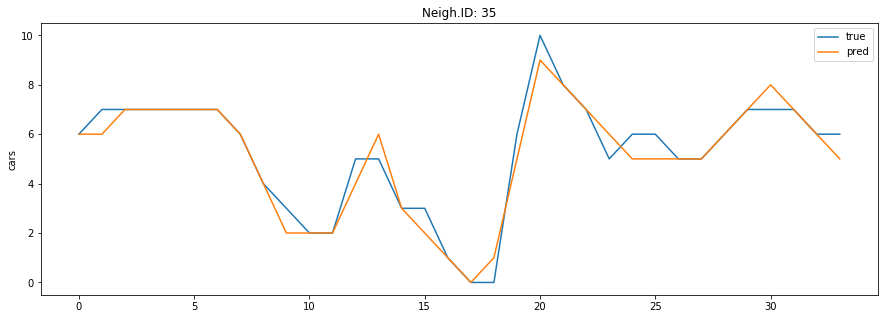

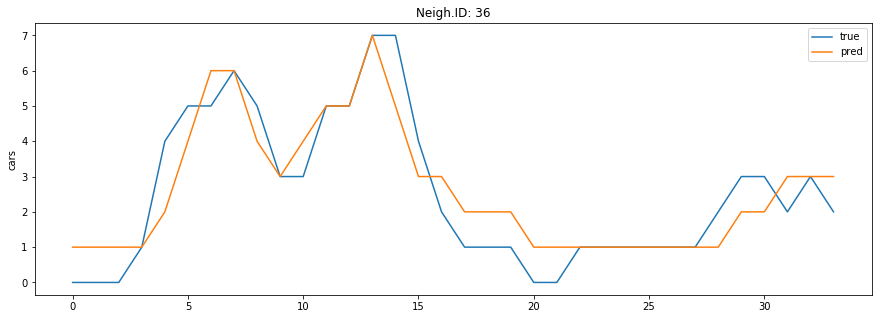

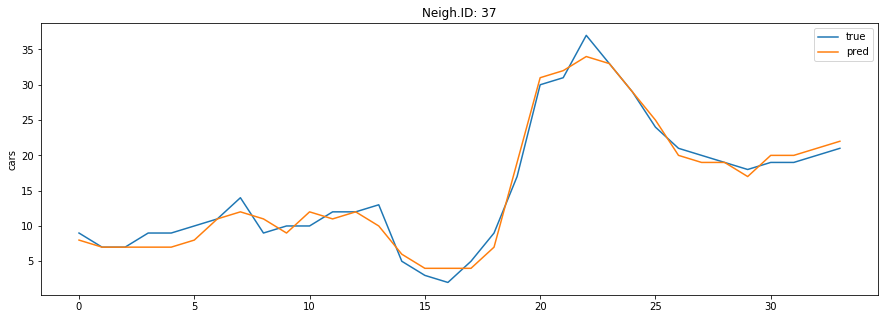

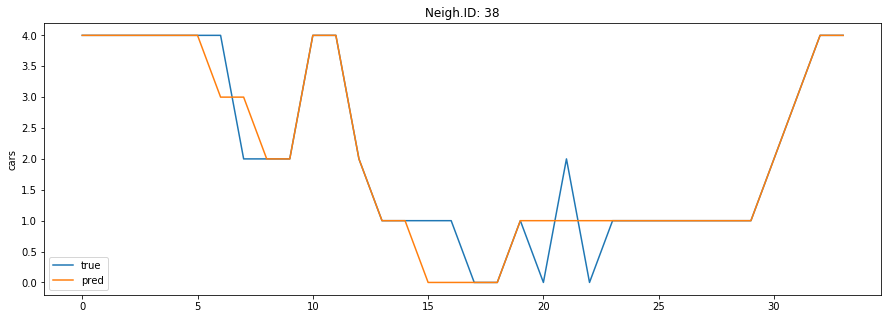

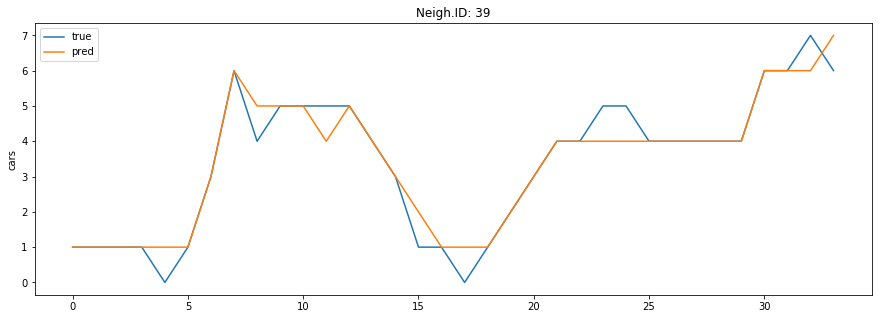

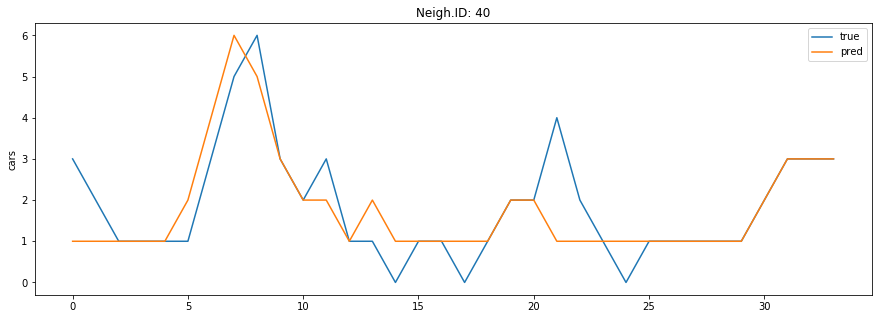

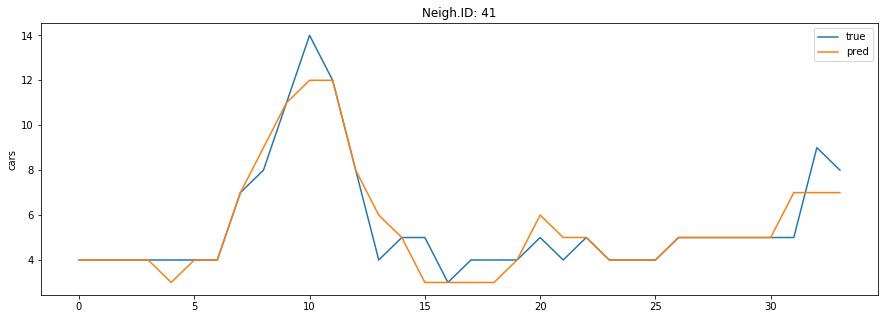

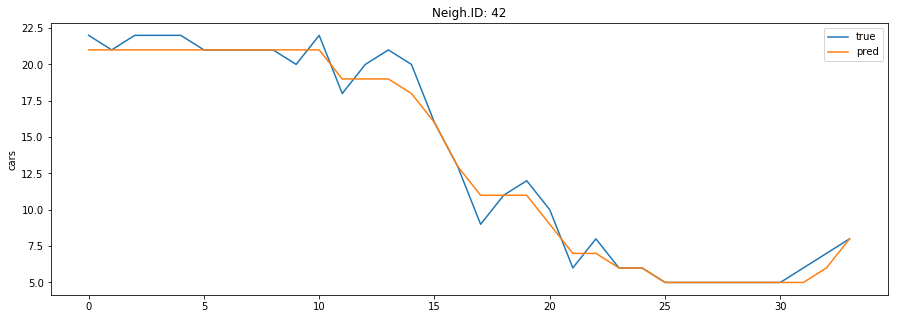

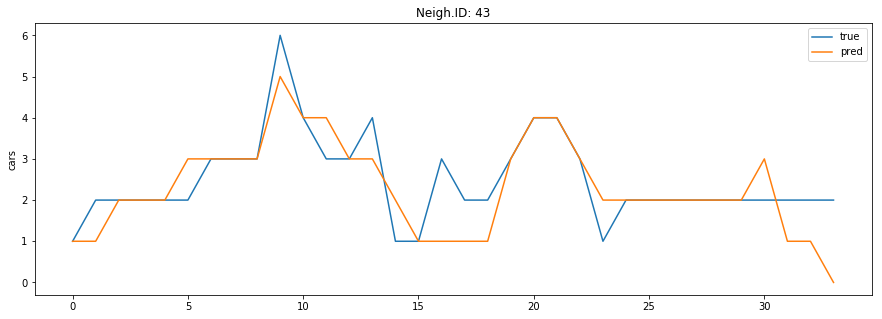

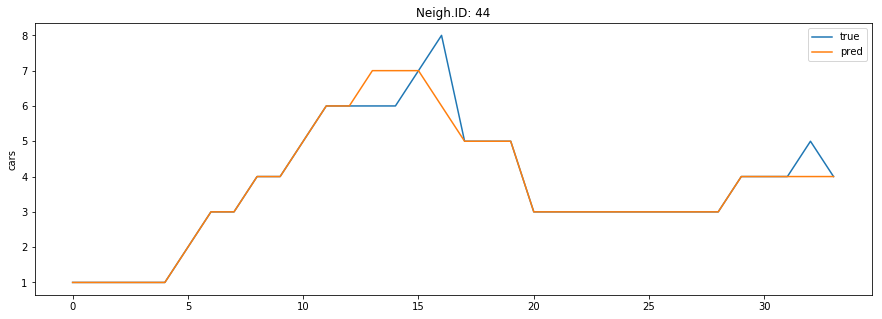

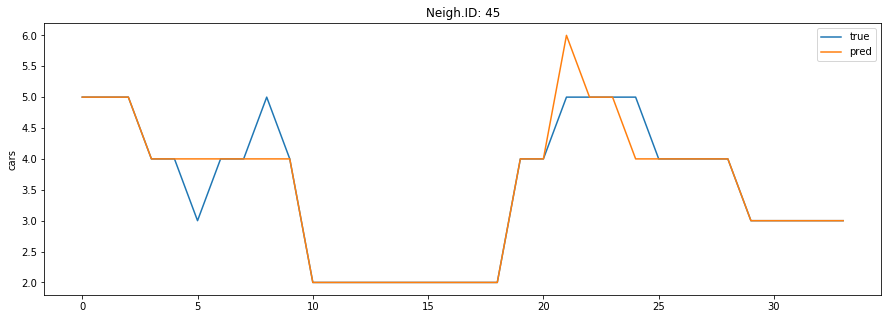

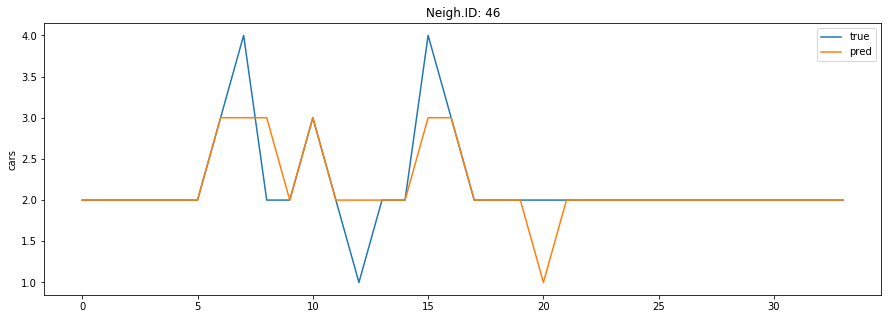

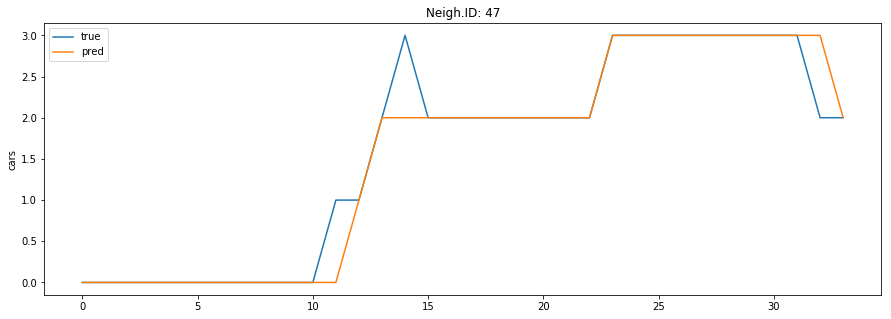

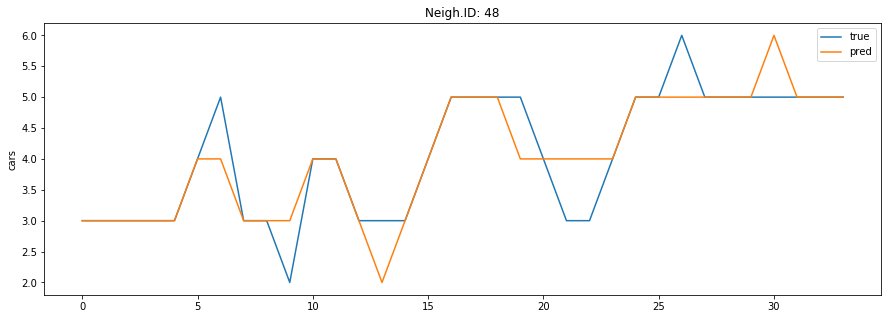

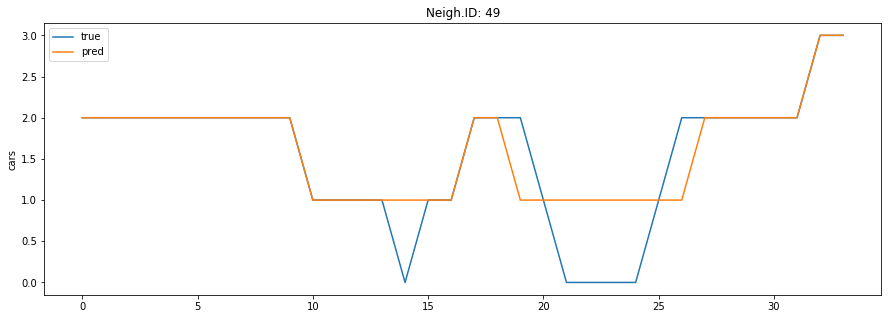

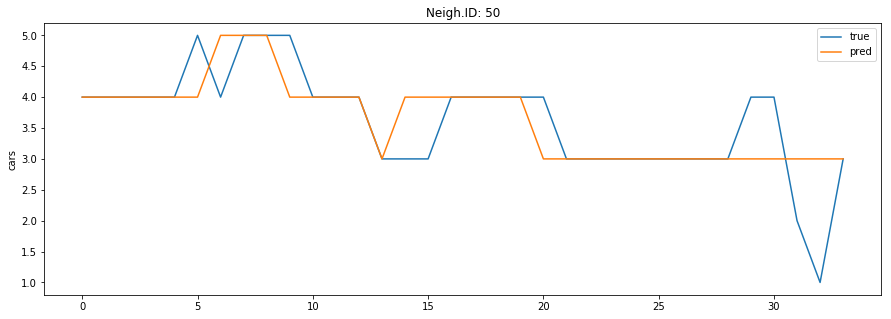

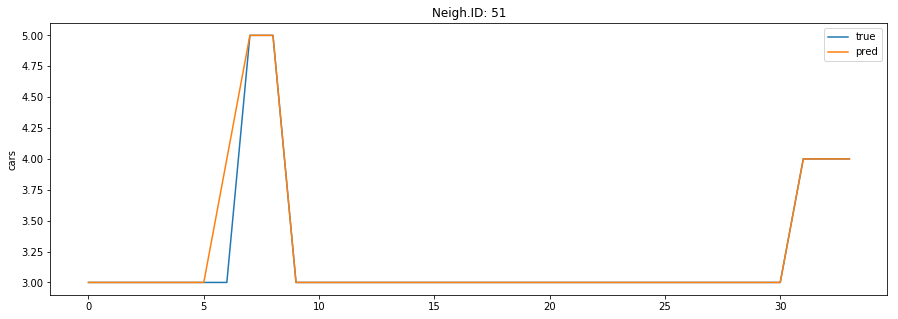

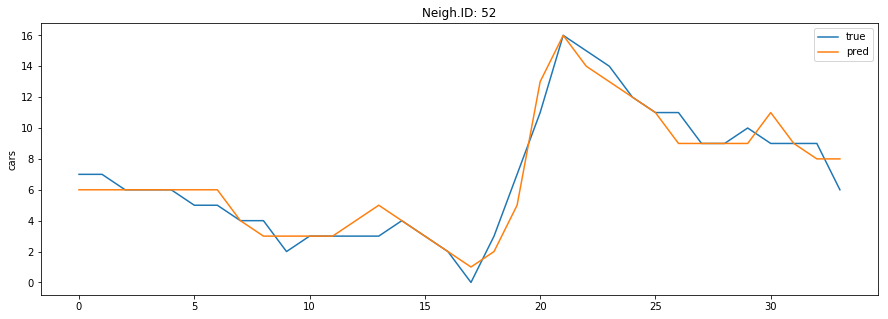

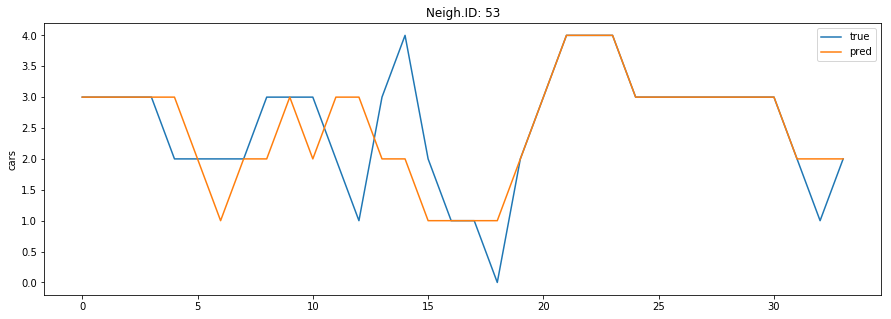

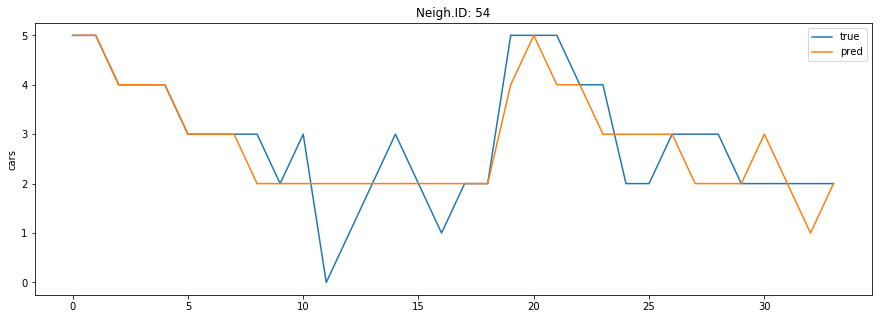

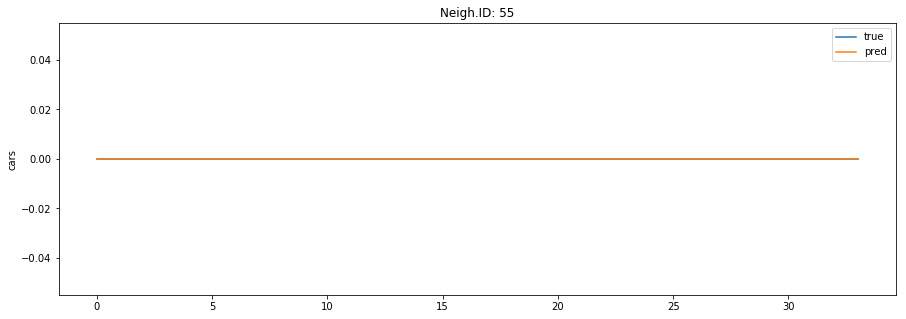

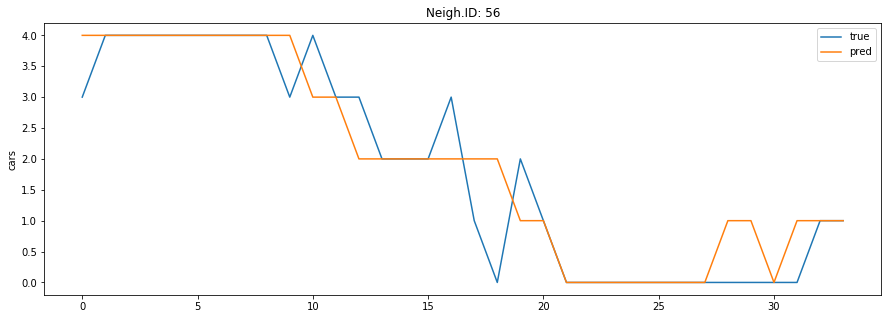

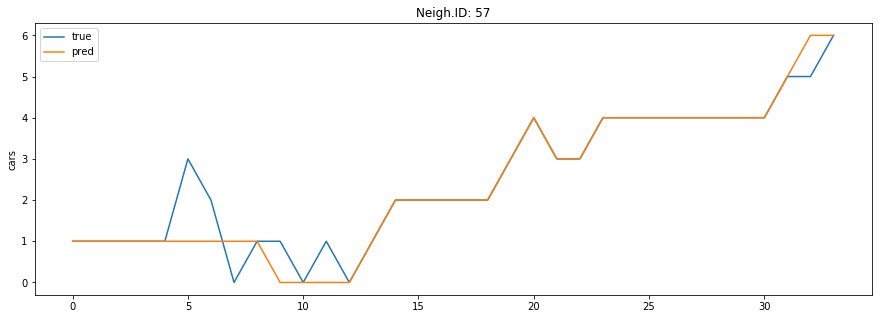

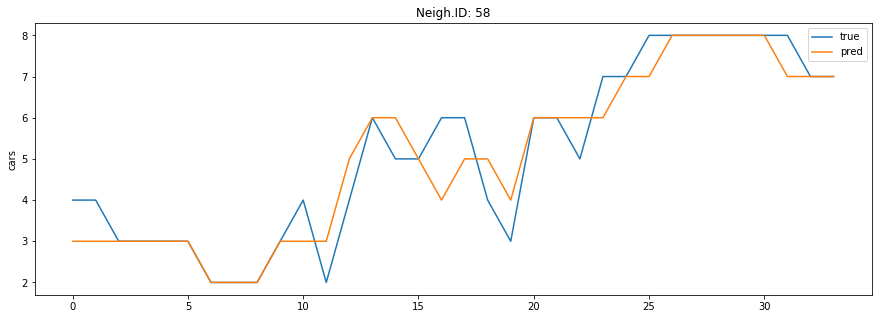

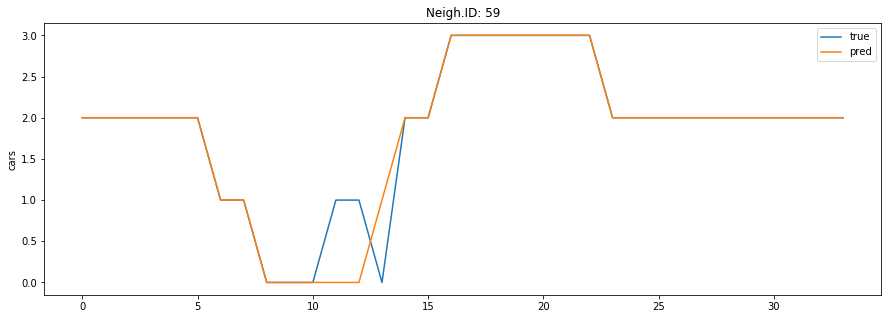

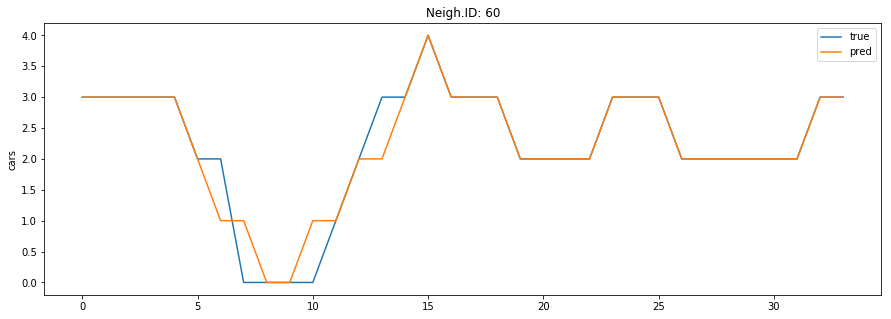

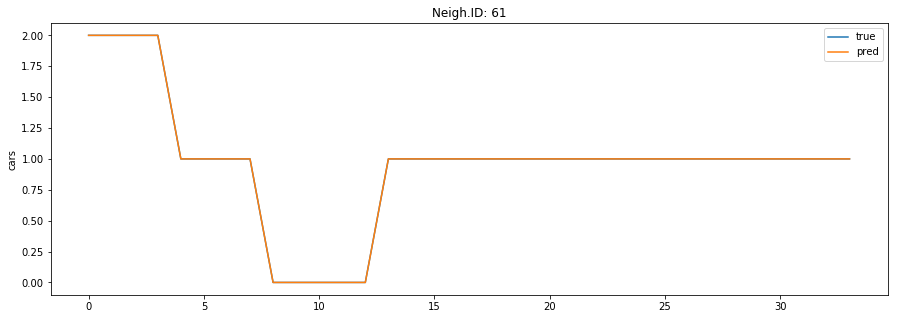

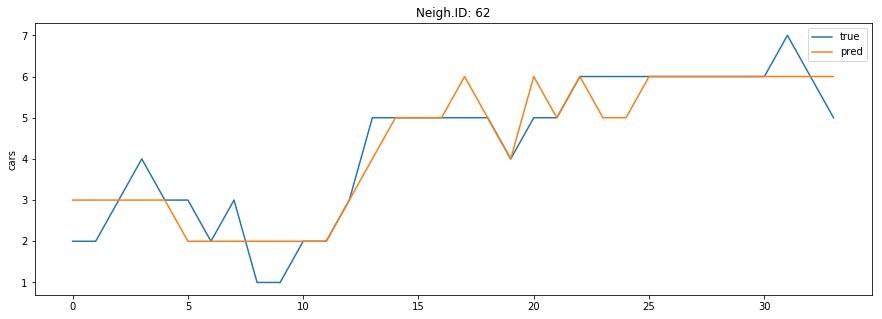

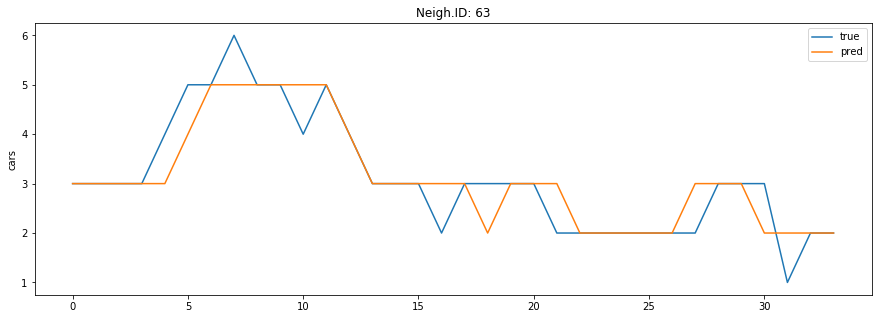

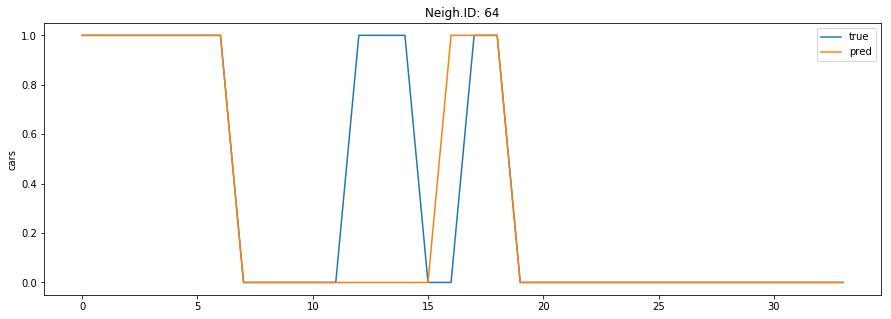

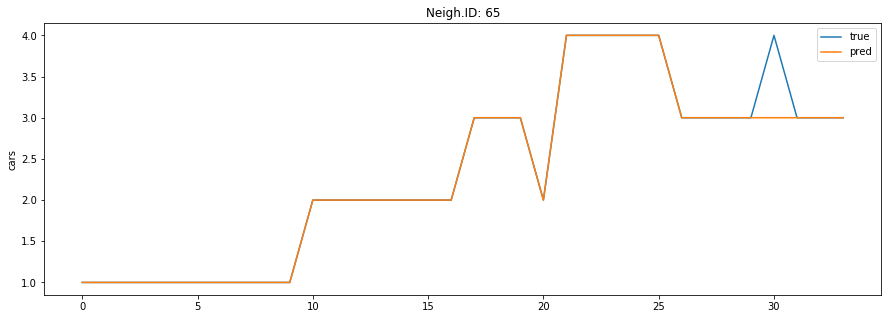

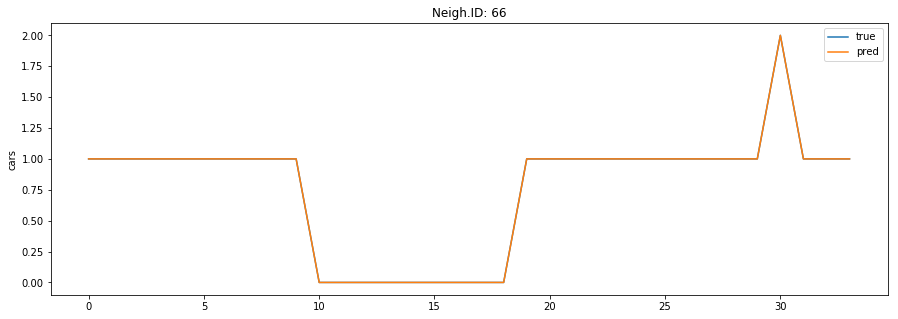

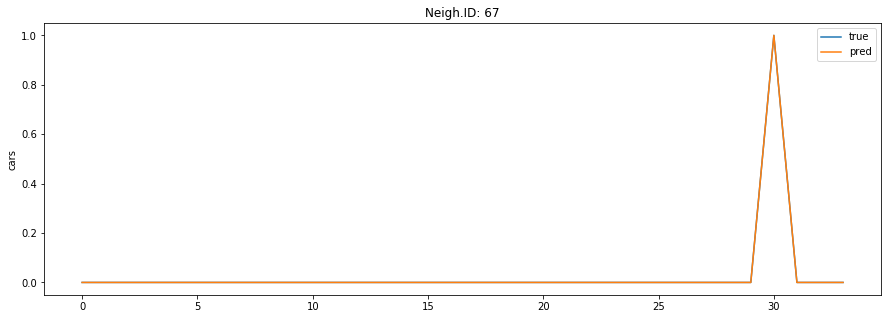

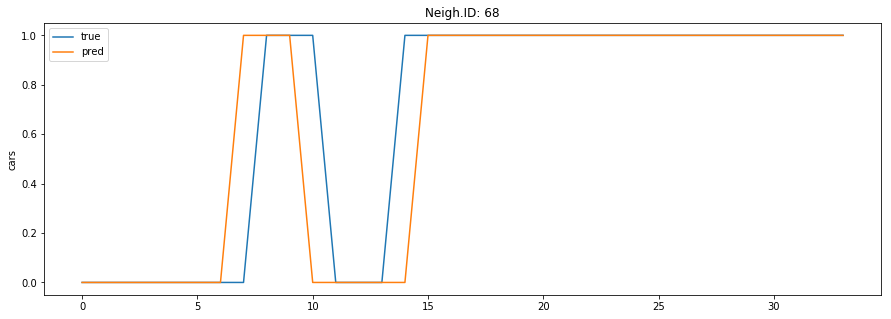

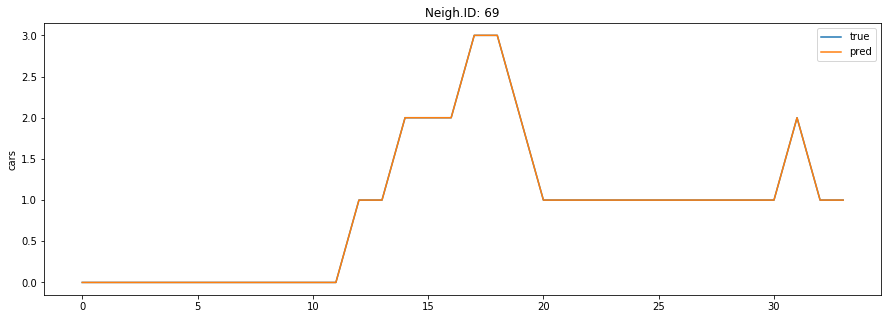

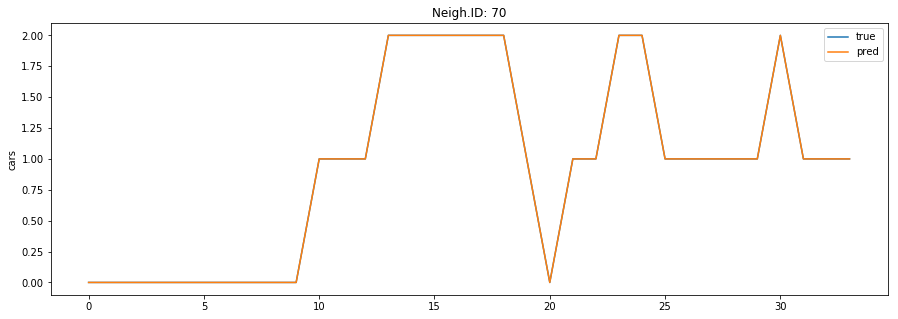

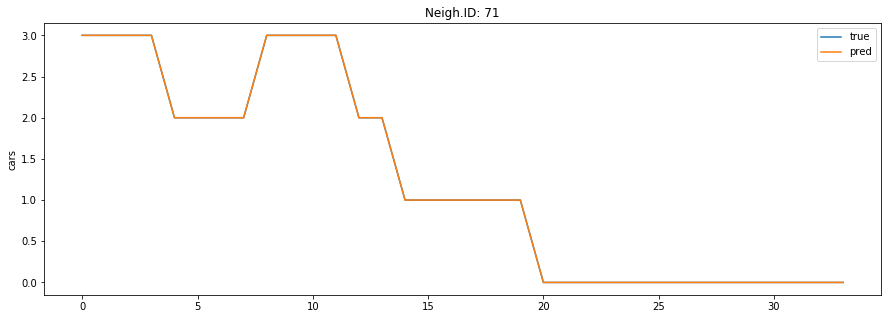

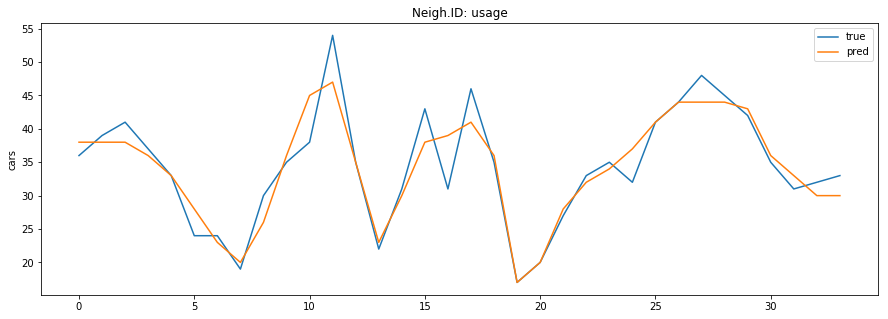

In [89]:
prediction, labels = plot_comparison()

## Forecasting with prediction Model 

In [90]:
prediction.shape, labels.shape

((34, 72), (34, 72))

In [91]:
forecast_df = pd.DataFrame(index=data.index[-34:] ,columns=target_data.columns[:], data = prediction)

labels_df = pd.DataFrame(index=data.index[-34:] ,columns=target_data.columns[:], data = labels)

In [93]:
forecast_df.head()

,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,usage
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-07 14:00:00,1.0,3.0,1.0,7.0,9.0,2.0,8.0,1.0,7.0,4.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,38.0
2019-01-07 15:00:00,1.0,3.0,1.0,8.0,9.0,2.0,8.0,1.0,7.0,4.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,38.0
2019-01-07 16:00:00,1.0,3.0,1.0,8.0,9.0,2.0,8.0,1.0,7.0,4.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,38.0
2019-01-07 17:00:00,1.0,3.0,1.0,8.0,9.0,2.0,8.0,1.0,7.0,4.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,36.0
2019-01-07 18:00:00,1.0,3.0,1.0,9.0,9.0,3.0,8.0,1.0,8.0,4.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,33.0


In [94]:
labels_df.head()

,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,usage
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-07 14:00:00,1.0,3.0,1.0,8.0,9.0,2.0,8.0,1.0,7.0,4.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,36.0
2019-01-07 15:00:00,1.0,3.0,1.0,8.0,9.0,2.0,8.0,1.0,7.0,4.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,39.0
2019-01-07 16:00:00,1.0,3.0,1.0,8.0,9.0,2.0,8.0,1.0,7.0,4.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,41.0
2019-01-07 17:00:00,1.0,3.0,1.0,8.0,9.0,2.0,8.0,1.0,7.0,4.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,37.0
2019-01-07 18:00:00,1.0,3.0,1.0,8.0,9.0,3.0,8.0,1.0,7.0,5.0,...,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,33.0


In [95]:
forecast_df.to_csv("forecast_34h.csv")
labels_df.to_csv("labels_34h.csv")